# Behavioral Cloning

In [1]:
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
import math
import load_policy

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def load_dataset(expert_observations, total_size = None, training_size_prop = 0.75):
    
    data = np.load(expert_obs).item()
    actions = data['actions'].squeeze()
    observations = data['observations']
    if total_size is None:
        total_size = actions.shape[0]
    actions = actions[0:total_size, :]
    observations = observations[0:total_size, :]
    N = total_size
    training_size = math.ceil(total_size * training_size_prop)
    
    train_x = observations[0:training_size, :]
    train_y = actions[0:training_size, :]

    test_x = observations[training_size:N, :]
    test_y = actions[training_size:N, :]
    
    return train_x, train_y, test_x, test_y

class DNNModel():
    def __init__(self, input_dim: int, hidden_dims: list, output_dim:int, activations: list, dropout=0, learning_rate=1e-3,
                 session = None):
        
        self.sess = tf.Session() if session is None else session
        
        self.x = tf.placeholder(tf.float32, shape=[None, input_dim], name='x')
        self.y = tf.placeholder(tf.float32, shape=[None, output_dim], name='y')

        if type(activations) is not list:
            activations = [activations] * len(hidden_dims)
        
        out = self.x
        for dim, act in zip(hidden_dims, activations):
            out = tf.layers.dense(out, dim, activation=act)
            out = tf.layers.dropout(out, rate=dropout)
            #out = tf.layers.batch_normalization(out)
            
        self.y_hat = tf.layers.dense(out, output_dim)
        self.loss = tf.reduce_mean(tf.squared_difference(self.y_hat, self.y))
        
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            self.minimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)
            
        self.sess.run(tf.global_variables_initializer())
    
    def train(self, train_x, train_y, batch_size=64, epochs=10, verbose=True, test_x = None, test_y = None):    
        training_loss = []
        test_loss = []
        for i in range(epochs):
            batch_losses = []
            for i in range(math.ceil(train_x.shape[0] / batch_size)):
                _, batch_loss = self.sess.run([self.minimizer, self.loss], feed_dict={self.x: train_x[batch_size*i : batch_size*(i+1), :],
                                                                                      self.y: train_y[batch_size*i : batch_size*(i+1), :]})
                batch_losses.append(batch_loss)
            if test_x is not None and test_y is not None:
                test_loss.append(self.sess.run([self.loss], feed_dict={self.x: test_x,
                                                                       self.y: test_y})[0])
            training_loss.append(np.mean(batch_losses))
        if len(test_loss) > 0:
            return training_loss, test_loss
        else:
            return training_loss
    
    def predict(self, x):
        return self.sess.run([self.y_hat], feed_dict={self.x: x})
    
def sample_environment(gym_env, predict_fn, max_steps= 1000, render=False):
    obs = gym_env.reset()
    observations = []
    observations.append(obs)
    rewards = []
    steps = 0
    done = False
    
    while not done:
        action = predict_fn(obs.reshape(1, input_dim))
        obs, r, done, _ = gym_env.step(action)
        if r == np.nan:
            break
        rewards.append(r)
        if render == True:
            gym_env.render()
        observations.append(obs)
        steps += 1
        if steps % 100 == 0: 
            print("%i/%i"%(steps, max_steps))
        if steps >= max_steps:
            break
    try:
        gym_env.close()
    except Exception:
        pass
    
    return observations, rewards, done

# Hopper-v1

In [2]:
expert_obs = './Hopper-v1_400.npy'
env = 'Hopper-v1'

train_x, train_y, test_x, test_y = load_dataset(expert_obs)

input_dim = train_x.shape[1]
output_dim = train_y.shape[1]

Test loss was 0.002816920867189765 with 10 epochs


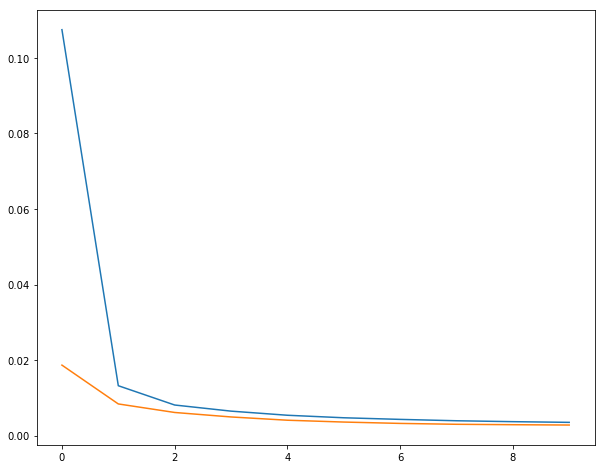

In [36]:
model = DNNModel(input_dim, [32], output_dim, activations=tf.nn.relu)

training_loss, test_loss = model.train(train_x, train_y, test_x = test_x, test_y = test_y, epochs=10, learning_rate=1e-3)

plt.plot(np.arange(len(training_loss)), training_loss, np.arange(len(test_loss)), test_loss)
print("Test loss was {} with {} epochs".format(test_loss[-1], len(test_loss)))    

In [42]:
betterModel = None
better_test_acc = math.inf

configs = {}

#hidden_layers = []
#for i in range(1):
#    hidden_layers.append(np.random.choice([2 ** i for i in range(3, 8)]))

for i in range(3):
    learning_rate = np.random.choice(np.logspace(-3.1,-2.7))
    dropout = np.random.choice(np.linspace(0.3, 0.6))
    hidden_layers = [64, 32]
    model = DNNModel(input_dim, hidden_layers, output_dim, activations=tf.nn.relu, dropout = dropout)
    training_loss, test_loss = model.train(train_x, train_y, 
                               test_x = test_x, test_y = test_y, 
                               epochs=15, 
                               learning_rate=learning_rate, batch_size=128)
    if test_loss[-1] < better_test_acc:
        better_test_acc = test_loss[-1]
        betterModel = model
    
    print(hidden_layers, learning_rate, dropout, (training_loss[-1], test_loss[-1]))

[64, 32] 0.00113527752649 0.495918367347 (0.0010588065, 0.00060880184)
[64, 32] 0.00113527752649 0.373469387755 (0.0011437773, 0.00059087819)
[64, 32] 0.000906030582245 0.373469387755 (0.0010555047, 0.00084925169)


In [ ]:
[32] 0.00049883760297 0.348979591837 (0.0022573171, 0.0020529535)
[64] 0.000582513671247 0.487755102041 (0.0013509203, 0.0010869333)
[128] 0.00102859615834 0.410204081633 (0.0010997332, 0.00071803521) <---
[32, 32] 0.00128281274271 0.414285714286 (0.0011997365, 0.0007727677)
[64, 32] 0.00142252931349 0.316326530612 (0.0012803351, 0.0007670687)

In [43]:
model = DNNModel(input_dim, [64, 32], output_dim, activations=tf.nn.relu, dropout = 0.316326530612)
model.train(train_x, train_y, 
            test_x = test_x, test_y = test_y, 
            epochs=15, 
            learning_rate=0.00142252931349, batch_size=128)


gym_env = gym.make(env)
obs = gym_env.reset()
done = False
steps = 0
max_steps = 1000

while not done:
    action = model.predict(obs.reshape(1, input_dim))
    obs, r, done, _ = gym_env.step(action)
    gym_env.render()
    steps += 1
    if steps % 100 == 0: 
        print("%i/%i"%(steps, max_steps))
    if steps >= max_steps:
        break
print('Was done? {}'.format(done))
try:
    gym_env.close()
except Exception:
    pass

[2018-01-27 01:12:12,549] Making new env: Hopper-v1
Exception ignored in: <bound method Env.__del__ of <TimeLimit<HopperEnv<Hopper-v1>>>>
Traceback (most recent call last):
  File "C:\Users\tiago\Anaconda3\envs\drlberkeley\lib\site-packages\gym\core.py", line 203, in __del__
    self.close()
  File "C:\Users\tiago\Anaconda3\envs\drlberkeley\lib\site-packages\gym\core.py", line 166, in close
    self._close()
  File "C:\Users\tiago\Anaconda3\envs\drlberkeley\lib\site-packages\gym\core.py", line 290, in _close
    return self.env.close()
  File "C:\Users\tiago\Anaconda3\envs\drlberkeley\lib\site-packages\gym\core.py", line 164, in close
    self.render(close=True)
  File "C:\Users\tiago\Anaconda3\envs\drlberkeley\lib\site-packages\gym\core.py", line 150, in render
    return self._render(mode=mode, close=close)
  File "C:\Users\tiago\Anaconda3\envs\drlberkeley\lib\site-packages\gym\envs\mujoco\mujoco_env.py", line 105, in _render
    self._get_viewer().finish()
  File "C:\Users\tiago\Ana

100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Was done? True


# Hopper-v1 with DAgger

In [2]:
expert_obs = './Hopper-v1_400.npy'
env = 'Hopper-v1'

train_x_dagger, train_y_dagger, test_x_dagger, test_y_dagger = load_dataset(expert_obs, total_size = 100000)
input_dim = train_x_dagger.shape[1]
output_dim = train_y_dagger.shape[1]

expert_fn = load_policy.load_policy("experts/{}.pkl".format(env))

obs (1, 11) (1, 11)


In [3]:
session = tf.InteractiveSession()
model = DNNModel(input_dim, [64, 32], output_dim, activations=tf.nn.relu, learning_rate=0.00142252931349, 
                 dropout = 0.316326530612, session=session)

gym_env = gym.make(env)

max_steps = 1000
rollouts = 10

for rollout in range(rollouts):
    print("rollout {}".format(rollout))
    training_loss, test_loss = model.train(train_x_dagger, train_y_dagger, 
                                           test_x = test_x_dagger, test_y = test_y_dagger, 
                                           epochs=10, batch_size=128)    
    print("training loss {} - test loss {}".format(training_loss[-1], test_loss[-1]))
    
    observations, rewards, done = sample_environment(gym_env, model.predict, max_steps = max_steps)
    
    print("average reward model: {}".format(np.mean(rewards)))
    actions_expert = []
    for i in range(len(observations)):
        actions_expert.append(expert_fn(observations[i].reshape(1, input_dim)))
        

    train_x_dagger = np.vstack([train_x_dagger, observations])
    train_y_dagger = np.vstack([train_y_dagger, np.array(actions_expert).squeeze()])
    
    print("")

    

[2018-02-23 12:39:31,999] Making new env: Hopper-v1


rollout 0
training loss 0.004263514187186956 - test loss 0.0034090341068804264
100/1000
200/1000
300/1000
average reward model: 3.304414964690118

rollout 1
training loss 0.004234440624713898 - test loss 0.051690541207790375
100/1000
200/1000
average reward model: 3.437503772691705

rollout 2
training loss 0.0036181278992444277 - test loss 0.09425783157348633
100/1000
200/1000
average reward model: 3.4273570414805055

rollout 3
training loss 0.003167410148307681 - test loss 0.06461130082607269
100/1000
200/1000
300/1000
average reward model: 3.5513323277434243

rollout 4
training loss 0.003878680756315589 - test loss 0.04823948070406914
100/1000
200/1000
average reward model: 2.9320226847947097

rollout 5
training loss 0.0023795717861503363 - test loss 0.03783496841788292
100/1000
200/1000
300/1000
average reward model: 3.560548706153397

rollout 6
training loss 0.0026770238764584064 - test loss 0.04627605155110359
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
average reward mo

In [9]:
session = tf.InteractiveSession()
model = DNNModel(input_dim, [64, 32], output_dim, activations=tf.nn.relu, learning_rate=0.00142252931349, 
                 dropout = 0.316326530612, session=session)
gym_env = gym.make(env)
sample_environment(gym_env, model.predict, max_steps = max_steps, render=True)

[2018-02-23 12:44:16,624] Making new env: Hopper-v1
Exception ignored in: <bound method Env.__del__ of <TimeLimit<HopperEnv<Hopper-v1>>>>
Traceback (most recent call last):
  File "C:\Users\tiago\Anaconda3\envs\drlberkeley\lib\site-packages\gym\core.py", line 203, in __del__
    self.close()
  File "C:\Users\tiago\Anaconda3\envs\drlberkeley\lib\site-packages\gym\core.py", line 166, in close
    self._close()
  File "C:\Users\tiago\Anaconda3\envs\drlberkeley\lib\site-packages\gym\core.py", line 290, in _close
    return self.env.close()
  File "C:\Users\tiago\Anaconda3\envs\drlberkeley\lib\site-packages\gym\core.py", line 164, in close
    self.render(close=True)
  File "C:\Users\tiago\Anaconda3\envs\drlberkeley\lib\site-packages\gym\core.py", line 150, in render
    return self._render(mode=mode, close=close)
  File "C:\Users\tiago\Anaconda3\envs\drlberkeley\lib\site-packages\gym\envs\mujoco\mujoco_env.py", line 105, in _render
    self._get_viewer().finish()
  File "C:\Users\tiago\Ana

([array([  1.24796346e+00,  -3.08689281e-03,  -2.30815518e-03,
           8.27633593e-04,  -3.83552763e-03,   3.14906880e-03,
           4.01517826e-03,  -4.65742638e-03,   4.71763044e-03,
          -2.08576635e-04,   1.14554566e-03]),
  array([  1.24769210e+00,  -1.82202643e-03,  -4.12089733e-04,
           2.65996234e-04,  -4.28958383e-03,   1.33392087e-02,
          -7.19038358e-02,   3.20472077e-01,   4.68712862e-01,
          -1.40005896e-01,  -1.14526149e-01]),
  array([  1.24683312e+00,  -3.96107208e-04,   2.39492792e-03,
          -1.51793105e-03,  -6.16109216e-03,  -2.00714729e-02,
          -1.42810119e-01,   2.86008887e-02,   2.23828562e-01,
          -3.05076399e-01,  -3.52976548e-01]),
  array([  1.24540264e+00,  -1.02129156e-03,   3.50586445e-03,
          -4.49649643e-03,  -9.85050802e-03,  -4.53350311e-02,
          -2.14889665e-01,  -1.71332659e-01,   7.05688333e-02,
          -4.40731835e-01,  -5.69306474e-01]),
  array([ 1.24339245, -0.00298142,  0.0037203 , -0.00859

In [5]:
gym_env.close()